In [23]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc
import meshio
import pandas as pd

np.random.seed(1234)

In [2]:
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.current_device())  # Should return an integer (GPU index)
print(torch.cuda.get_device_name(torch.cuda.current_device()))  # GPU name

True
0
NVIDIA GeForce RTX 2060


In [3]:
# CUDA support
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

print(f"Using device: {device}")

torch.backends.cudnn.benchmark = True

Using device: cuda


In [4]:
class DNN(nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        modules = []
        for i in range(len(layers) - 2):  # Exclude last layer for activation
            modules.append(nn.Linear(layers[i], layers[i+1]))
            modules.append(nn.Tanh())
        modules.append(nn.Linear(layers[-2], layers[-1]))  # Last layer (no activation)
        self.network = nn.Sequential(*modules)

        for layer in self.network:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)

    def forward(self, x):
        return self.network(x)

In [5]:
class PINN():
    def __init__(self, dnn):

        self.track_loss = []

        self.w_pde = 1
        self.w_bc = 1
        self.lr_adam = 0.01
        self.lr_lbfgs = 0.005

        # DNN
        self.dnn = dnn

        # Optimizer
        self.optimizer_lbfgs = torch.optim.LBFGS(
            self.dnn.parameters(),
            lr=self.lr_lbfgs,
            max_iter=20000,
            max_eval=20000,
            history_size=200,
            tolerance_grad=1e-10,
            tolerance_change=1e-10,
        )

        self.optimizer_adam = torch.optim.Adam(self.dnn.parameters(), lr=self.lr_adam)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer_adam, step_size=4000, gamma=0.5)
        self.iter = 0

    def set_var(self, X, Y, masks, h, l, r, nu):
        self.x = torch.tensor(X, requires_grad=True).float().to(device).view(-1, 1)
        self.y = torch.tensor(Y, requires_grad=True).float().to(device).view(-1, 1)
        self.data = torch.cat((self.x, self.y), dim=1)

        self.mask_left = masks['left']
        self.mask_top = masks['top']
        self.mask_right = masks['right']
        self.mask_down = masks['down']
        self.mask_hole1 = masks['hole1']
        self.mask_hole2 = masks['hole2']

        self.nu = nu

        self.h = h
        self.l = l
        self.r = r

        self.cx1 = l/4 + 0.1
        self.cx2 = 3*l/4 - 0.1
        self.cy = h/2

        self.w_pde = 1
        self.w_bc = 1

    def model_value(self, data):
        out = self.dnn(data)
        u = out[:,0:1]
        v = out[:,1:2]
        sxx = out[:,2:3]
        syy = out[:,3:4]
        sxy = out[:,4:5]
        return u, v, sxx, syy, sxy

    def pde_loss(self, u, v, sxx, syy, sxy, data):


        du = torch.autograd.grad(u, data, torch.ones_like(u), create_graph=True)[0]
        dx_u = du[:, 0:1]
        dy_u = du[:, 1:2]

        dv = torch.autograd.grad(v, data, torch.ones_like(v), create_graph=True)[0]
        dx_v = dv[:, 0:1]
        dy_v = dv[:, 1:2]

        dx_sxx = torch.autograd.grad(sxx, data, torch.ones_like(sxx), create_graph=True)[0][:, 0:1]
        dy_syy = torch.autograd.grad(syy, data, torch.ones_like(syy), create_graph=True)[0][:, 1:2]
        dsxy = torch.autograd.grad(sxy, data, torch.ones_like(sxy), create_graph=True)[0]
        dx_sxy = dsxy[:, 0:1]
        dy_sxy = dsxy[:, 1:2]

        term_xx = 1 / (1 - self.nu**2) * (dx_u + self.nu*dy_v)
        term_yy = 1 / (1 - self.nu**2) * (dy_v + self.nu*dx_u)
        term_xy = 1 / (2*(1 + self.nu)) * (dy_u + dx_v)

        r1 = torch.mean(torch.pow((sxx - term_xx), 2))
        r2 = torch.mean(torch.pow((syy - term_yy), 2))
        r3 = torch.mean(torch.pow((sxy - term_xy), 2))
        r4 = torch.mean(torch.pow((dx_sxx + dy_sxy), 2))
        r5 = torch.mean(torch.pow((dy_syy + dx_sxy), 2))

        residual = r1 + r2+ r3 + r4 + r5
        return residual

    def bc_loss(self, u, v, sxx, syy, sxy, data):

        b = torch.mean(torch.pow(u[self.mask_left] + 1, 2))
        b += torch.mean(torch.pow(v[self.mask_left], 2))

        b += torch.mean(torch.pow(syy[self.mask_top], 2))
        b += torch.mean(torch.pow(sxy[self.mask_top], 2))

        b += torch.mean(torch.pow(sxx[self.mask_right] - 1, 2))
        b += torch.mean(torch.pow(sxy[self.mask_right], 2))

        b += torch.mean(torch.pow(syy[self.mask_down], 2))
        b += torch.mean(torch.pow(sxy[self.mask_down], 2))

        x = data[:, 0:1]
        y = data[:, 1:2]
        nx1 = -(x[self.mask_hole1]-self.cx1)/self.r
        ny1 = -(y[self.mask_hole1]-self.cy)/self.r
        tx1 = torch.mul(sxx[self.mask_hole1], nx1) + torch.mul(sxy[self.mask_hole1], ny1)
        ty1 = torch.mul(sxy[self.mask_hole1], nx1) + torch.mul(syy[self.mask_hole1], ny1)

        b += torch.mean(torch.pow(tx1, 2))
        b += torch.mean(torch.pow(ty1, 2))

        nx2 = -(x[self.mask_hole2]-self.cx2)/self.r
        ny2 = -(y[self.mask_hole2]-self.cy)/self.r
        tx2 = torch.mul(sxx[self.mask_hole2], nx2) + torch.mul(sxy[self.mask_hole2], ny2)
        ty2 = torch.mul(sxy[self.mask_hole2], nx2) + torch.mul(syy[self.mask_hole2], ny2)

        b += torch.mean(torch.pow(tx2, 2))
        b += torch.mean(torch.pow(ty2, 2))       

        return b

    
    def loss_func(self):
        u, v, sxx, syy, sxy = self.model_value(self.data)
        pde = self.pde_loss(u, v, sxx, syy, sxy, self.data)
        bc = self.bc_loss(u, v, sxx, syy, sxy, self.data)
        return pde, bc


    def lbfgs_func(self):
        pde_loss, bc_loss = self.loss_func()
        loss = self.w_pde*pde_loss + self.w_bc*bc_loss
        self.optimizer_lbfgs.zero_grad()
        loss.backward()

        self.track_loss.append(loss.item())

        if self.iter % 100 == 0:
            print(f"Iter: {self.iter}, Loss: {'{:e}'.format(loss.item())}")
        self.iter += 1
        return loss
    
    def train(self, epochs=1000):
        self.dnn.train()
        for epoch in range(epochs):
            pde_loss, bc_loss = self.loss_func()
            loss = self.w_pde*pde_loss + self.w_bc*bc_loss

            self.optimizer_adam.zero_grad()
            loss.backward()
            self.optimizer_adam.step()
            self.scheduler.step()

            self.track_loss.append(loss.item())

            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {'{:e}'.format(loss.item())}")
                print(f"PDE: {'{:e}'.format(pde_loss.item())}, BC: {'{:e}'.format(bc_loss.item())}")
        self.optimizer_lbfgs.step(self.lbfgs_func)

    def predict(self, x, y):
        x = torch.tensor(x, dtype=torch.float, device=device).view(-1, 1)
        y = torch.tensor(y, dtype=torch.float, device=device).view(-1, 1)
        data = torch.cat((x, y), dim=1)

        self.dnn.eval()
        u, v, sxx, syy, sxy = self.model_value(data)
        u = u.detach().cpu().numpy()
        v = v.detach().cpu().numpy()
        sxx = sxx.detach().cpu().numpy()
        syy = syy.detach().cpu().numpy()
        sxy = sxy.detach().cpu().numpy()
        return u, v, sxx, syy, sxy

In [6]:
def sample_sobol_points(N, l, h, hole1, hole2, scramble=False):

    sampler = qmc.Sobol(d=2, scramble=scramble)
    points = []
    count = 0

    B = max(1024, N)
    while len(points) < N:
        batch = sampler.random(n=B)
        xs, ys = batch[:, 0]*l, batch[:, 1]*h

        ok1 = (xs - hole1[0])**2 + (ys - hole1[1])**2 >= hole1[2]**2
        ok2 = (xs - hole2[0])**2 + (ys - hole2[1])**2 >= hole2[2]**2
        mask = ok1 & ok2

        valid = np.stack([xs[mask], ys[mask]], axis=1)
        needed = N - len(points)
        points.extend(valid[:needed])             # take only what we still need

    return np.array(points)

In [15]:
def generate_lhs_points_with_holes(
    domain_bounds,                # [(x_min, x_max), (y_min, y_max)]
    holes,                        # list of (center_x, center_y, radius)
    n_points                      # total number of valid points desired
):
    dim = len(domain_bounds)
    sampler = qmc.LatinHypercube(d=dim)   # Use LHS instead of Sobol

    # Oversample and filter
    factor = 1.5  # oversampling factor
    while True:
        m = int(n_points * factor)
        u = sampler.random(m)  # [m, 2] in unit cube
        pts = qmc.scale(u, [b[0] for b in domain_bounds], [b[1] for b in domain_bounds])
        
        # Filter out points inside any hole
        mask = np.ones(len(pts), dtype=bool)
        for cx, cy, r in holes:
            dist2 = (pts[:, 0] - cx) ** 2 + (pts[:, 1] - cy) ** 2
            mask &= dist2 > r ** 2
        
        valid_pts = pts[mask]
        if len(valid_pts) >= n_points:
            return valid_pts[:n_points]
        else:
            # Increase oversampling factor and try again
            factor *= 1.5

In [16]:
def generate_points(n_d, n_b, domain_bounds, holes):
    
    x_min, x_max = domain_bounds[0]
    y_min, y_max = domain_bounds[1]

    sampler_1d = qmc.LatinHypercube(d=1)
    # sampler_2d = qmc.LatinHypercube(d=2)

    dom = generate_lhs_points_with_holes(domain_bounds, holes, n_d)
    dom_x = dom[:, 0]
    dom_y = dom[:, 1]

    points = sampler_1d.random(n_b)

    left_x = np.ones(n_b) * x_min
    left_y = qmc.scale(points, y_min, y_max).flatten()

    top_x = qmc.scale(points, x_min, x_max).flatten()
    top_y = np.ones(n_b) * y_max

    right_x = np.ones(n_b) * x_max
    right_y = qmc.scale(points, y_min, y_max).flatten()

    down_x = qmc.scale(points, x_min, x_max).flatten()
    down_y = np.ones(n_b) * y_min

    cx1, cy1, r1 = holes[0]
    cx2, cy2, r2 = holes[1]

    theta = qmc.scale(points, 0, 2*np.pi).flatten()
    hole1_x = cx1 + r1*np.cos(theta)
    hole1_y = cy1 + r1*np.sin(theta)

    hole2_x = cx2 + r2*np.cos(theta)
    hole2_y = cy2 + r2*np.sin(theta)

    dom_x = np.hstack((dom_x, hole1_x, hole2_x, left_x, top_x, right_x, down_x))
    dom_y = np.hstack((dom_y, hole1_y, hole2_y, left_y, top_y, right_y, down_y))

    mask_left = np.equal(dom_x, x_min)
    mask_top = np.equal(dom_y, y_max)
    mask_right = np.equal(dom_x, x_max)
    mask_down = np.equal(dom_y, y_min)
    rad1 = np.sqrt((dom_x - cx1)**2 + (dom_y - cy1)**2)
    rad2 = np.sqrt((dom_x - cx2)**2 + (dom_y - cy2)**2)
    mask_hole1 = np.isclose(rad1, r1)
    mask_hole2 = np.isclose(rad2, r2)
    masks = {'left': mask_left, 'top': mask_top, 'right': mask_right, 'down': mask_down, 'hole1': mask_hole1, 'hole2': mask_hole2}

    return dom_x, dom_y, masks

In [17]:
l = 2.0
h = 1.0
r = 0.1
nu = 0.33

cx1 = l/4 + 0.1
cx2 = 3*l/4 - 0.1
cy = h/2


domain_bounds = [(0, l), (0, h)]
holes = [(cx1, cy, r), (cx2, cy, r)]

X, Y, masks = generate_points(50000, 2000, domain_bounds, holes)

nodes = 64
layers = [2] + 6 * [nodes] + [5]

In [18]:
mask_left = masks["left"]
mask_top = masks["top"]
mask_right = masks["right"]
mask_down = masks["down"]
mask_hole1 = masks["hole1"]
mask_hole2 = masks["hole2"]

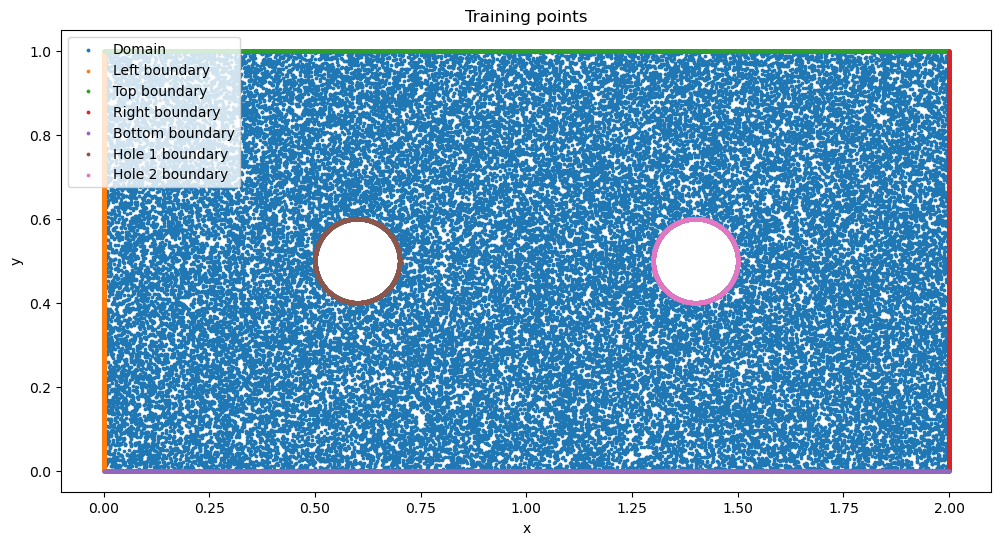

In [19]:
plt.figure(figsize=(12, 6))

plt.scatter(X, Y, label="Domain", s=3)
plt.scatter(X[mask_left], Y[mask_left], label="Left boundary", s=3)
plt.scatter(X[mask_top], Y[mask_top], label="Top boundary", s=3)
plt.scatter(X[mask_right], Y[mask_right], label="Right boundary", s=3)
plt.scatter(X[mask_down], Y[mask_down], label="Bottom boundary", s=3)
plt.scatter(X[mask_hole1], Y[mask_hole1], label="Hole 1 boundary", s=3)
plt.scatter(X[mask_hole2], Y[mask_hole2], label="Hole 2 boundary", s=3)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Training points")
plt.legend(loc="upper left")
plt.show()

In [20]:
model = DNN(layers).to(device)

In [21]:
pinn = PINN(model)
pinn.set_var(X, Y, masks, h, l, r, nu)

In [22]:
pinn.train(10000)  

Epoch 0, Loss: 2.990626e+00
PDE: 5.564061e-01, BC: 2.434220e+00
Epoch 100, Loss: 2.777900e-01
PDE: 2.946218e-02, BC: 2.483278e-01
Epoch 200, Loss: 2.103280e-01
PDE: 5.756922e-02, BC: 1.527588e-01
Epoch 300, Loss: 1.934504e-01
PDE: 5.260899e-02, BC: 1.408414e-01
Epoch 400, Loss: 1.550558e-01
PDE: 5.771796e-02, BC: 9.733786e-02
Epoch 500, Loss: 1.338265e-01
PDE: 6.323379e-02, BC: 7.059275e-02
Epoch 600, Loss: 1.930796e-01
PDE: 1.242410e-01, BC: 6.883860e-02
Epoch 700, Loss: 1.069877e-01
PDE: 5.365951e-02, BC: 5.332815e-02
Epoch 800, Loss: 1.003761e-01
PDE: 5.035407e-02, BC: 5.002206e-02
Epoch 900, Loss: 1.106603e-01
PDE: 5.981082e-02, BC: 5.084952e-02
Epoch 1000, Loss: 9.622194e-02
PDE: 4.942589e-02, BC: 4.679604e-02
Epoch 1100, Loss: 9.428259e-02
PDE: 4.894081e-02, BC: 4.534178e-02
Epoch 1200, Loss: 9.343328e-02
PDE: 4.924856e-02, BC: 4.418472e-02
Epoch 1300, Loss: 9.341753e-02
PDE: 4.843308e-02, BC: 4.498445e-02
Epoch 1400, Loss: 9.127747e-02
PDE: 4.905197e-02, BC: 4.222550e-02
Epoch 1

In [33]:
print(pinn.iter)

10784


In [70]:
# Save model
torch.save(pinn.dnn.state_dict(), "models/two_holes_6_64.pth")

In [12]:
# Load model
model = PINN(dom_x, dom_y, masks, layers, h, l, r, nu)
model.dnn.load_state_dict(torch.load("models/two_holes.pth", weights_only=True))

<All keys matched successfully>

In [72]:
x_p = 100
y_p = 100

x = np.linspace(0, l, x_p)
y = np.linspace(0, h, y_p)
X, Y = np.meshgrid(x, y)

points = np.vstack((X.ravel(), Y.ravel())).T

distances1 = np.sqrt((points[:, 0] - cx1)**2 + (points[:, 1] - cy)**2)
distances2 = np.sqrt((points[:, 0] - cx2)**2 + (points[:, 1] - cy)**2)
mask = np.greater(distances1, r) & np.greater(distances2, r)

filtered_points = points[mask]


x_pred = filtered_points[:, 0].reshape(-1, 1)
y_pred = filtered_points[:, 1].reshape(-1, 1)

u, v, sxx, syy, sxy = pinn.predict(x_pred, y_pred)

In [73]:
L = 2  # Length of the sheet
H = 1   # Height of the sheet
nx, ny = 10, 10  # Number of grid points in x and y
E = 7e10  # Young's modulus (Pa)
sigma_0 = 50e6  # Applied stress (Pa)

U = sigma_0 / E

u = u*U
v = v*U
sxx = sxx*sigma_0
syy = syy*sigma_0
sxy = sxy*sigma_0


In [74]:
von_mises = np.sqrt(sxx**2 + syy**2 - sxx*syy + 3*sxy**2)
print(von_mises)

[[60446888.]
 [58969128.]
 [57783304.]
 ...
 [50061884.]
 [49949616.]
 [49854392.]]


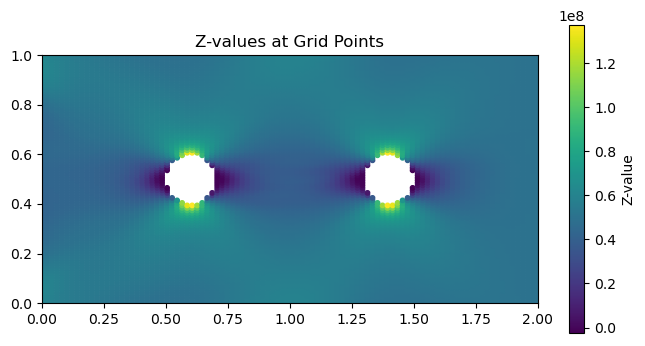

In [76]:
plt.figure(figsize=(8, 4))
sc = plt.scatter(x_pred, y_pred, c=sxx, cmap='viridis', s=10)
plt.colorbar(sc, label="Z-value")
plt.title("Z-values at Grid Points")  
plt.xlim(0, l)
plt.ylim(0, h)
plt.gca().set_aspect('equal')
plt.show()

In [26]:
csv_file = "data/2hole_horizontal_r10.csv"
df = pd.read_csv(csv_file, sep=",", skipinitialspace=True)

In [27]:
mesh_file = "meshes/2holes_horizontal_r10_o1.inp"
mesh = meshio.read(mesh_file)

In [28]:
print(df.columns)

Index(['Node ID', 'Equivalent Stress', 'Stress X', 'Stress Y', 'Deformation X',
       'Deformation Y', 'Shear'],
      dtype='object')


In [29]:
von_miss = df["Equivalent Stress"].values
nodes = mesh.points[:,:2]
a = len(nodes)
node_features = torch.tensor(von_miss[:a], dtype=torch.float).view(-1, 1)

print(len(nodes))

print(len(node_features[:a]))

10770
10770


In [30]:
from torch_geometric.data import Data

edges = []
for cell in mesh.cells:
    if cell.type == "triangle":
        for element in cell.data:
            edges.append([element[0], element[1]])
            edges.append([element[1], element[0]])

            edges.append([element[1], element[2]])
            edges.append([element[2], element[1]])

            edges.append([element[2], element[0]])
            edges.append([element[0], element[2]])

edges = torch.tensor(edges, dtype=torch.long).t().contiguous()
pos = torch.tensor(nodes, dtype=torch.float)

data = Data(x=node_features, edge_index=edges, pos=pos)
print(data.x.shape)
print(data.pos.shape)

torch.Size([10770, 1])
torch.Size([10770, 2])


In [31]:
x = pos[:, 0:1].detach().cpu().numpy()
y = pos[:, 1:2].detach().cpu().numpy()

u, v, sxx, syy, sxy = pinn.predict(x, y)

E = 7e10  # Young's modulus (Pa)
sigma_0 = 50e6  # Applied stress (Pa)

U = sigma_0 / E

u = u*U
v = v*U
sxx = sxx*sigma_0
syy = syy*sigma_0
sxy = sxy*sigma_0
von_mises = np.sqrt(sxx**2 + syy**2 - sxx*syy + 3*sxy**2)
fem_von = node_features.detach().cpu().numpy()

In [32]:
l2_error = np.linalg.norm(von_mises - fem_von) / np.linalg.norm(fem_von, 2)
print(l2_error)

0.033500355


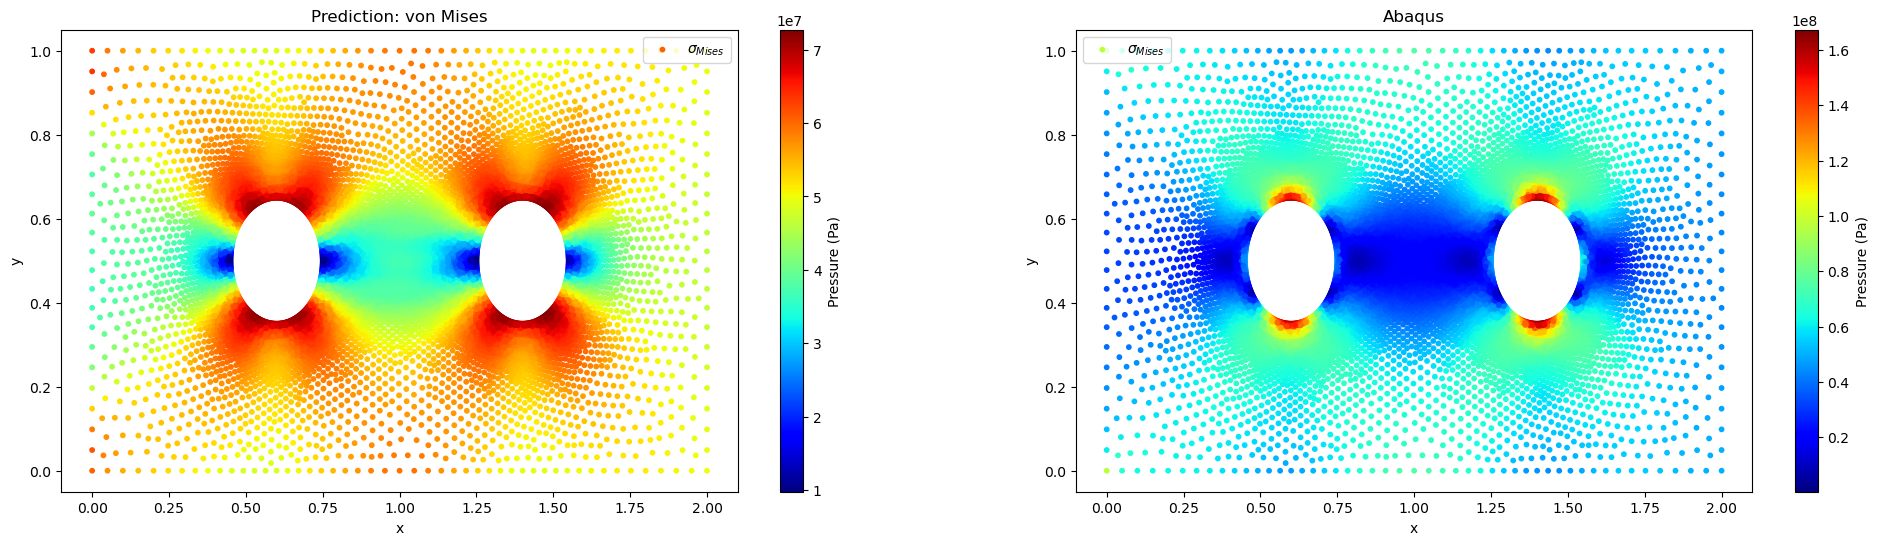

In [86]:
import matplotlib.tri as tri

triang = tri.Triangulation(x.flatten(), y.flatten())

x_tri = x.flatten()[triang.triangles].mean(axis=1)
y_tri = y.flatten()[triang.triangles].mean(axis=1)

hole_center = (0.6, 0.5)
hole_radius = 0.1

mask = (x_tri - hole_center[0])**2 + (y_tri - hole_center[1])**2 < hole_radius**2
triang.set_mask(mask)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 6), sharex=True)

color_map = 'jet'

sc1 = ax1.scatter(x, y, c=von_mises, cmap=color_map, s=10, label=r'$\sigma_{Mises}$')
ax1.legend(loc='upper right')
ax1.set_title('Prediction: von Mises')
ax1.set_xlabel("x")
ax1.set_ylabel("y")
c1 = plt.colorbar(sc1)
c1.set_label("Pressure (Pa)")

sc2 = ax2.scatter(x, y, c=fem_von, cmap=color_map, s=10, label=r'$\sigma_{Mises}$')
ax2.legend(loc='upper left')
ax2.set_title('Abaqus')
ax2.set_xlabel("x")
ax2.set_ylabel("y")
c2 = plt.colorbar(sc2)
c2.set_label("Pressure (Pa)")

In [26]:
x_fem = df['X'].values.reshape(-1, 1)
y_fem = df['Y'].values.reshape(-1, 1)

u, v, sxx, syy, sxy = model.predict(x_fem, y_fem)

E = 7e10  # Young's modulus (Pa)
sigma_0 = 50e6  # Applied stress (Pa)

U = sigma_0 / E

u = u*U
v = v*U
sxx = sxx*sigma_0
syy = syy*sigma_0
sxy = sxy*sigma_0


1.0686884967352401


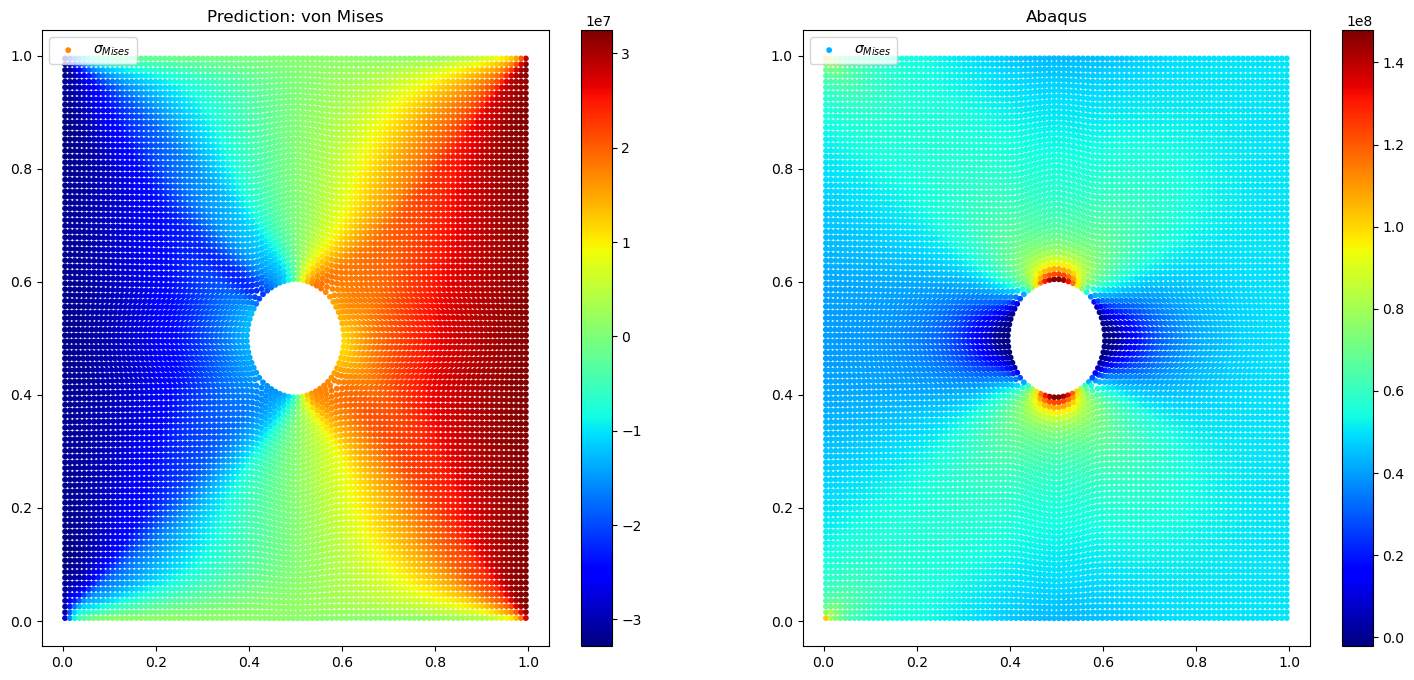

In [28]:
sxx_fem = df['S-S11'].values.reshape(-1, 1)
von_mises = np.sqrt(sxx**2 + syy**2 - sxx*syy + 3*sxy**2)
sxx_error = np.abs(von_mises - sxx_fem)
l2_error = np.linalg.norm(sxx - sxx_fem) / np.linalg.norm(sxx_fem, 2)
print(l2_error)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8), sharex=True)

color_map = 'jet'

sc1 = ax1.scatter(x_fem, y_fem, c=sxx, cmap=color_map, s=10, label=r'$\sigma_{Mises}$')
ax1.legend(loc='upper left')
ax1.set_title('Prediction: von Mises')

plt.colorbar(sc1)

sc2 = ax2.scatter(x_fem, y_fem, c=sxx_fem, cmap=color_map, s=10, label=r'$\sigma_{Mises}$')
ax2.legend(loc='upper left')
ax2.set_title('Abaqus')
plt.colorbar(sc2)


plt.show()

In [18]:
mises_pred = von_mises
mises_abaqus = df['S-Mises'].values.reshape(-1, 1)

max_pred = np.max(mises_pred)
max_abaqus = np.max(mises_abaqus)

m_pred = np.mean(mises_pred)
m_abaqus = np.mean(mises_abaqus)

factor_pred = max_pred / m_pred
factor_abaqus = max_abaqus / m_abaqus

print(f"My model: {factor_pred}")
print(f"Abaqus: {factor_abaqus}")

My model: 2.823540687561035
Abaqus: 2.8129607579943294


In [19]:
d = 0.2
H = 1

K = 0.284 + 2 / (1 - d/H) - 0.6*(1-d/H) + 1.32*(1-d/H)**2
print(K*(1-d/H))

2.5190400000000004
